In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

# Computer Science Grades

This notebook will be analyzing grades from computer science papers (specifically those from the University of Otago!). We have data from the previous four years (2019-2022). This data was taken from Freedom of Information requests to the University of Otago, specifically from [this request](https://fyi.org.nz/request/21065-grade-distribution-of-papers#incoming-80077) and [this request](https://fyi.org.nz/request/22139-grade-distribution-for-200-and-300-level-cosc-and-info-papers#incoming-83891).

We start by taking the given `.xlsx` files (see the `RawDataFiles` directory) and manually stripping the data out into a more usable `.csv` format (see `data/papers`). This is the most tedious part of the project - as we must extract individual tables and add labels for years and semesters.

We have data on the number of students that achieved each grade (as a number) for each paper. Therefore, we could analyze the distribution of those grades and see if there is a deviation across different years for the same paper, or aggregated across all papers for that year.

With these files, we can load the data into pandas DataFrames. We can also load some aggregated data into a separate DataFrame so we can investigate some relationships across all papers. For example, because all papers have a PaperCode in the form of `COSCXYZ` where X, Y, and Z are digits, and X representing the year level of the paper, we could aggregate the grades for each year level to see if grades improve as students move through their degree.

In [18]:
# Define the directory for the data files
dataDirectory = "data"
# Define the subdirectory (within the dataDirectory) that holds the papers csv files
papersDataDirectory = os.path.join(dataDirectory, "papers")

# Define columns that indicate an instance of a paper
# A unique combination of theses is a single paper
groupbyColumns = ["Year", "Semester"]

# Aggregate data on papers
allPapers = pd.DataFrame()

# Collect all paper dataframes into a single dictionary, keyed by the papercode
papersdfs = {}

for filepath in os.listdir(papersDataDirectory):
    # Get the papercode (from the file name)
    filename = os.path.splitext(filepath)[0]
    # Load the data frame and put it into our paperdfs map
    paperData = pd.read_csv(os.path.join(papersDataDirectory, filepath))
    papersdfs[filename] = paperData

    # Get some base data for each instance of this paper
    # We use unique values of Year and Semester as this indicates an instance
    uniquePaperInstance = paperData[groupbyColumns].drop_duplicates()
    baseData = {
        "PaperCode": [],
        "Year": [],
        "Semester": [],
        "Level": [],
    }
    for _, row in uniquePaperInstance.iterrows():
        baseData["PaperCode"].append(filename)
        baseData["Year"].append(row["Year"])
        baseData["Semester"].append(row["Semester"])
        baseData["Level"].append(f"{filename[-3]}00")
    currentPaper = pd.DataFrame.from_dict(baseData)
    
    # Aggregate number of students over each instance of this paper
    numberOfStudentsAggregation = paperData[[*groupbyColumns, "Number of Students"]].groupby(groupbyColumns).aggregate(np.sum).reset_index()
    currentPaper["TotalStudents"] = numberOfStudentsAggregation["Number of Students"]

    # Aggregate the average mark over each instance of this paper
    averageMarkAggregation = paperData[[*groupbyColumns, "Mark"]].copy()
    averageMarkAggregation["Mark"] = pd.to_numeric(averageMarkAggregation["Mark"], errors="coerce")
    averageMarkAggregation = averageMarkAggregation.dropna()
    if len(averageMarkAggregation) > 0:
        averageMarkAggregation = averageMarkAggregation.groupby(groupbyColumns).aggregate(np.average).reset_index()
        currentPaper["AverageMark"] = averageMarkAggregation["Mark"]

    allPapers = pd.concat([allPapers, currentPaper])

allPapers = allPapers.sort_values(by="PaperCode")
allPapers.to_csv(os.path.join(dataDirectory, "allPapers.csv"))

## Total Number of Students Per Paper

Let's have a look at the number of students in each paper and in each year!

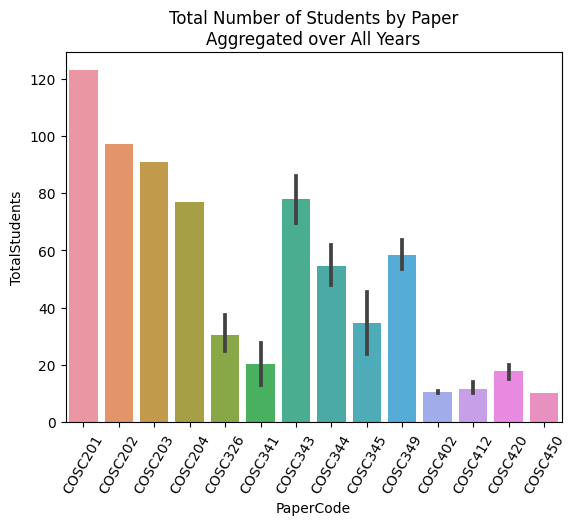

In [10]:
sns.barplot(allPapers, x="PaperCode", y="TotalStudents")
plt.title(f"Total Number of Students by Paper\nAggregated over All Years")
plt.xticks(rotation=60)
plt.show()

It appears at a cursory glance that the 200 level papers have a higher number of students than the 300 level papers, which in turn have a higher number of students than the 400 level papers. This seems reasonable, as we expect the number f students to fall off as the degree continues (for example, it is relatively common for students to drop out part way through a degree, not enrolling in higher level papers, compared to students suddenly attending high level papers without completing the prerequisites). This, of course, assumes that the number of students across the years is roughly constant, so the pipeline of students moving through the paper levels is unaffected by time. This is probably not true (the university grows over time, roughly with population!) but is reasonable in the timeframe we are analyzing. We should look more closely at the number of students by year level.

We also notice that not all papers have an associated error bar. This is due to some papers only having one instance in the data. For example, at the time of data collection, the 200 level papers (`COSC201`, `COSC202`, `COSC203`, `COSC204`) have only run once, as they are new! This is not ideal, but it is still interesting enough to analyze.

It appears that the 200 level papers have some drop off from semester 1 (`COSC201`, `COSC202`) to semester 2 (`COSC203`, `COSC204`). I would guess that students that have weaker mathematics skills would be most likely to drop the degree after `COSC201`. This could explain the drop from semester 1 to semester 2. 

There also seems to be a difference in the 200 level papers even within a semester. `COSC203` seems more popular than `COSC204` - even though both are required for a computer science degree! Perhaps some of this could be attributed to students delaying taking `COSC204` (after all, these are new papers!), but I think the more likely reason is that students taking minors in computer science need to only take 2 200 level papers and are excluding `COSC204` as it is seen as "more difficult".

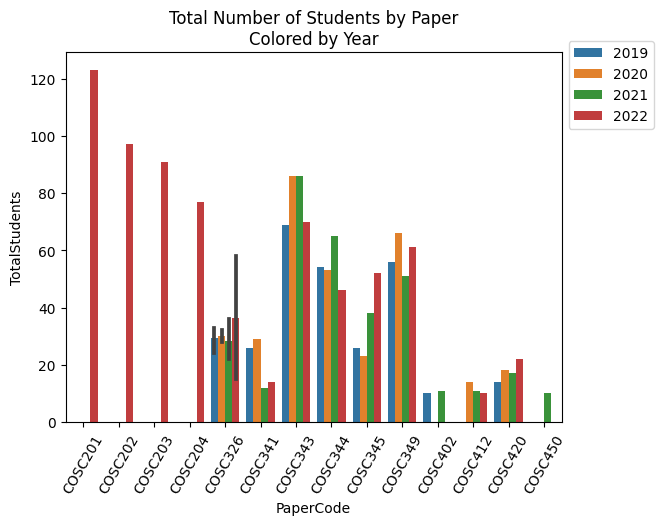

In [11]:
sns.barplot(allPapers, x="PaperCode", y="TotalStudents", hue="Year")
plt.title(f"Total Number of Students by Paper\nColored by Year")
plt.legend(bbox_to_anchor=(1, 1.05))
plt.xticks(rotation=60)
plt.show()

Separating the papers into the years we can start to spot some patterns. While we can hypothesize on these trends, we absolutely cannot state anything with certainty as we do not have enough data over enough time to be sure!

We see that `COSC301` ("Theory of Computing": a paper on formal computer science) appears to have dropped in popularity recently. This could be due to declining numbers due to COVID over this timespan, although the same trend is not present in other 300 level papers. I cannot think of any reason that this paper would decline in popularity so rapidly. I believe this is simply sampling variation and is to be expected. `COSC344` ("Databases") also seems to share this feature.

Interestingly, `COSC345` ("Software Engineering") has seen rapid growth in this timeframe. Again, this could be due to sampling variation, or it could be due to increased interest in getting hard software development skills in what is traditionally a students final year.

Finally, we can see that `COSC420` ("Advanced Artificial Intelligence / Deep Learning") has had steady growth recently. This paper, as with all 400 level papers, has a relatively low enrollment as most students don't reach 400 level papers (traditionally these are taken in an honours degree rather than a regular bachelors). This trend could be explained by the recently introduced Masters of AI, as well as an increase in interest in AI generally. `COSC343` ("Artificial Intelligence") does not seem to have the same trend (at least not to the same extent"), so perhaps the Masters of AI is the dominant factor and interest in AI is already at saturation in the student population.

Other papers are relatively flat in terms of enrollment (or don't have enough instances to tell!). 

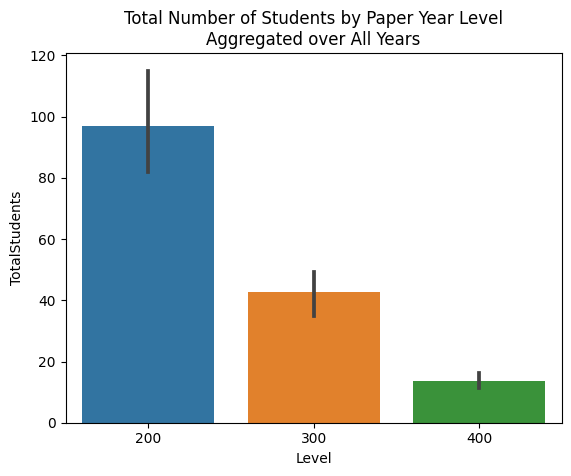

In [20]:
sns.barplot(allPapers, x="Level", y="TotalStudents")
plt.title(f"Total Number of Students by Paper Year Level\nAggregated over All Years")
plt.show()

Splitting the data by year level now, we see clearly that as the level of the paper increases, the number of students enrolled decreases. 

For the decrease from 200 to 300 level, this is probably due to students either dropping out, or students undertaking "only" a minor in computer science (requiring one 300 level paper rather than four for the major).

For the decrease from 300 to 400 level, this is almost certainly due to most students not taking an honours degree, instead graduating with a bachelors and leaving tertiary education entirely.

However, we must also consider that this data is taken in the time frame of 2019-2022: meaning the COVID-19 pandemic or other global factors could be skewing the results compared to what is typical! Perhaps more students are in higher education as a whole as businesses commence layoffs, or less students on average a continuing onto honours degrees as tech startups offer more jobs. It would require a lot more data in many more areas to say anything with confidence!